In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [2]:
df=pd.read_csv('./data/tweets.csv', names=['index','genre','summary']).drop(columns='index')

In [6]:
df

,genre,summary
0,0,Starting back at work today Looks like it'l...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! have a great summer break!
3,1,hannah montana was very good. now going to re...
4,1,"@Mayra326 aww, have fun! I just had my 3D las..."
...,...,...
149980,0,Had a great night at Tabs but now I'm missing ...
149981,1,What a night at work.. Church in the morning
149982,0,this book is terrible im used 2 reading all ...
149983,0,@backstreetboys Updates? Any? I miss your upd...


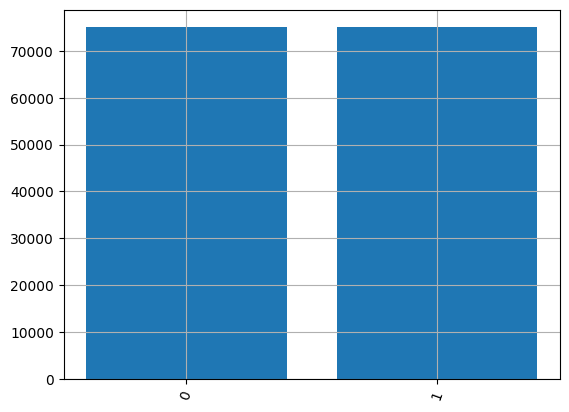

In [3]:
names,counts=np.unique(df.genre, return_counts=True)

plt.bar(np.arange(df.genre.nunique()),
        height=counts)
plt.grid()
plt.xticks(np.arange(df.genre.nunique()), names, rotation=70)
plt.show()

In [ ]:
vocab=set()
max_len=0
for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
    vocab=vocab.union(set(summary))
    max_len=max(max_len, len(summary))
max_len, len(vocab)

<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_8001/738898365.py:3: SyntaxWarning: invalid escape sequence '\W'
  for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
100%|██████████| 4657/4657 [00:04<00:00, 1028.53it/s]


(5750, 55715)

# custom tokenizer

In [23]:
def get_training_corpus():
    for i in range(0, df.shape[0], 100):
        yield df.summary.values[i : i + 100]

In [26]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

In [ ]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

# gpt2 tokenizer

In [4]:
from transformers import GPT2Tokenizer, AutoTokenizer

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

In [6]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token 
tokenized_summary=gpt2_tokenizer(df.summary.map(lambda x: x.strip().lower()).tolist(),
                    return_tensors='pt',
                    padding=True)
tokenized_summary['input_ids'].shape

torch.Size([149985, 835])

In [7]:
tokenized_summary['input_ids'].numpy().shape

(149985, 835)

In [8]:
tokenized_summary

{'input_ids': tensor([[38690,   220,   736,  ..., 50256, 50256, 50256],
        [   82, 35652,  2974,  ..., 50256, 50256, 50256],
        [   31, 21070,   500,  ..., 50256, 50256, 50256],
        ...,
        [ 5661,  1492,   318,  ..., 50256, 50256, 50256],
        [   31,  1891, 25662,  ..., 50256, 50256, 50256],
        [   31,  2588,   769,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [9]:
tokenized_summary['input_ids'].numpy().reshape(df.shape[0], 1, -1).shape

(149985, 1, 835)

In [17]:
df['input_ids']=[list(x) for x in tokenized_summary['input_ids'].numpy()]
df['att_mask']=[list(x) for x in tokenized_summary['attention_mask'].numpy()]

In [18]:
genre_dict={}
for i, g in enumerate(df.genre.unique()):
    genre_dict[g]=i

In [19]:
df['label']=df.genre.map(lambda x: genre_dict[x])

In [20]:
tokens_set=set()
for tokens in df.input_ids.values:
    tokens_set=tokens_set.union(set(tokens))
tokens_dict={}
for i, t in enumerate(tokens_set):
    tokens_dict[t]=i

In [21]:
df['mapped_inputs']=df.input_ids.map(lambda x: [tokens_dict[t] for t in x])

In [24]:
df.drop(columns='Unnamed: 0', inplace=True)
df

,title,genre,summary,input_ids,att_mask,label,mapped_inputs
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,"[67, 2053, 276, 29445, 3462, 318, 262, 717, 36...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[37, 1722, 165, 17871, 2821, 203, 151, 573, 21..."
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...","[292, 262, 1492, 9808, 11, 474, 888, 3253, 316...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[181, 151, 1259, 7200, 11, 341, 732, 2671, 188..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,"[66, 1018, 417, 318, 3538, 25562, 416, 262, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[36, 847, 288, 203, 2876, 16024, 287, 151, 135..."
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,"[1169, 1492, 9808, 351, 28783, 12, 25561, 410,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[981, 1259, 7200, 232, 17559, 12, 16023, 282, ..."
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,"[18870, 272, 290, 308, 3686, 72, 423, 4504, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[12576, 161, 179, 197, 2987, 42, 294, 3595, 17..."
...,...,...,...,...,...,...,...
4652,Hounded,fantasy,"Atticus O’Sullivan, last of the Druids, lives ...","[1078, 24552, 267, 447, 247, 82, 16040, 11, 93...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[900, 15528, 156, 317, 136, 52, 10964, 11, 780..."
4653,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,"[354, 7063, 494, 19236, 338, 7932, 8855, 6140,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[235, 5369, 361, 12767, 221, 5949, 6556, 4723,..."
4654,Red Rising,fantasy,"""I live for the dream that my children will be...","[1, 72, 2107, 329, 262, 4320, 326, 616, 1751, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[1, 42, 1767, 213, 151, 3461, 211, 475, 1482, ..."
4655,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...","[13698, 10408, 5391, 49510, 11, 5391, 49510, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,"[9624, 7583, 4235, 26024, 11, 4235, 26024, 105..."


In [25]:
df.to_parquet('./data/books.par')